# Evaluate the finetuned model

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from ase.db import connect
from random import shuffle
from pathlib import Path
import numpy as np
import shutil
import subprocess
from ase.io import read

Set the MD file and create a directory for outputs

In [2]:
md_run_file = "../data/md-runs/propanol/md-run.xyz" #The xyz output file that we got from the molecular dynamics
models = ["mace_run-21940057", "mace_run-27650412", "mace_run-10739442"]

outputs_dir = "data"
if not Path(outputs_dir).exists():
    outputs_dir.mkdir()

Create a subprocess command to run the eval_configs.py script from MACE, but this time to evaluate finetuning

In [3]:
commands = {}
for model in models:
    if not Path(f"{outputs_dir}/{model}.xyz").exists():
        commands[model] = [
            "python",
            "../../../mace/scripts/eval_configs.py",
            "--model", f"../runs/checkpoints/{model}.model",
            "--device", "cuda",
            "--output", f"{outputs_dir}/{model}.xyz",
            "--configs", md_run_file
        ]

In [4]:
for command in commands.values():
    subprocess.run(command)

Parse the output xyz file and get the predicted and real force and energy values

Plot the performance of the model for both energy and force

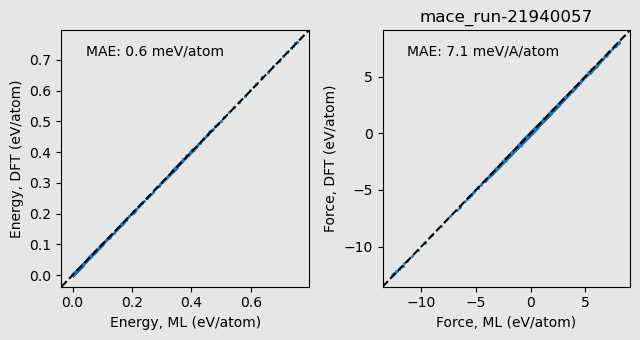

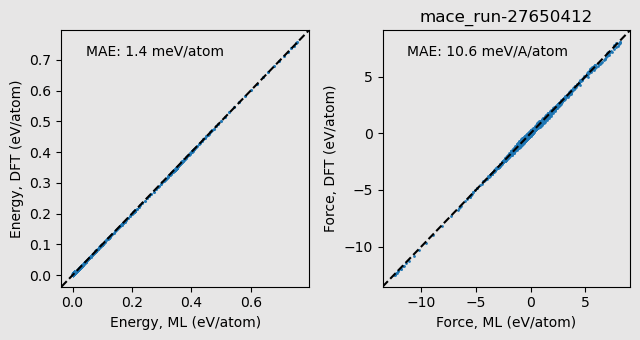

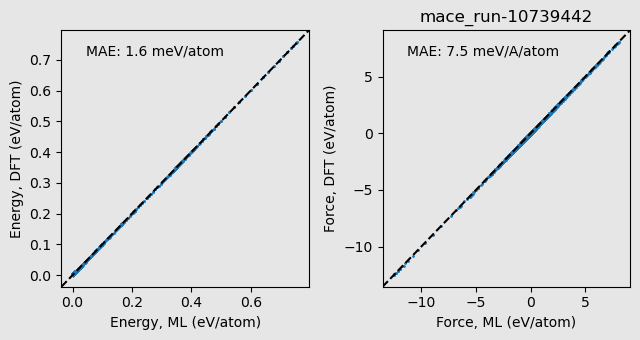

In [7]:
for name in models:
    data = read(f"{outputs_dir}/{name}.xyz", index=":")
    ml_energy = [molecule.info["MACE_energy"] for molecule in data]
    ml_forces = [molecule.arrays["MACE_forces"] for molecule in data]
    real_energy = [molecule.info["energy"] for molecule in data]
    real_forces = [molecule.arrays["forces"] for molecule in data]

    fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5))

    # Plot the energies
    ax = axs[0]
    n_atoms = [molecule.get_number_of_atoms() for molecule in data]
    ml_energies = np.divide(ml_energy, n_atoms)
    dft_energies = np.divide(real_energy, n_atoms)
    ax.scatter(ml_energies - min(ml_energies), dft_energies - dft_energies.min(), s=1.5)
    mae_e = np.abs(np.divide(ml_energy, n_atoms) - dft_energies).mean()
    ax.text(0.1, 0.9, f'MAE: {mae_e*1000:.1f} meV/atom', transform=ax.transAxes)

    ax.set_xlabel('Energy, ML (eV/atom)')
    ax.set_ylabel('Energy, DFT (eV/atom)')
    ax.set_facecolor("#e7e6e6")

    # Plot the forces
    ax = axs[1]
    dft_forces = np.vstack(real_forces).flatten()
    ml_forces = np.vstack(ml_forces).flatten()
    ax.scatter(ml_forces, dft_forces, s=1)
    ax.set_title(name)
    mae_f = np.abs(ml_forces - dft_forces).mean()
    ax.text(0.1, 0.9, f'MAE: {mae_f*1000:.1f} meV/A/atom', transform=ax.transAxes)

    ax.set_xlabel('Force, ML (eV/atom)')
    ax.set_ylabel('Force, DFT (eV/atom)')
    ax.set_facecolor("#e7e6e6")

    for ax in axs:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_ylim())

        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    
    fig.set_facecolor("#e7e6e6")
    fig.tight_layout()